## STAT841 
### Winter 2023 - Final Project
---
**Group member names and UW student ID numbers: **
* _Yujia Zheng (20789867)_
* _Kaiden Liu (20730764)_
* _Xiyao Wang (20704844)_
* _Patricia Wang (20708162)_

### Import Data

In [ ]:
# Import useful packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from scipy.stats import randint
import xgboost as xgb
import joblib

In [ ]:
# Define a function for computing model evaluation metrics.
def eval_model(y_test, y_preds):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds, pos_label=1)
    # TP vs. FP
    auc_roc = metrics.auc(fpr, tpr)

    precision, recall, _ = metrics.precision_recall_curve(y_test, y_preds)
    auc_pr = metrics.auc(recall, precision)

    print(f"ROC-AUC: {auc_roc} \n PR-AUC {auc_pr}")

    # fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    # roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()



### Data Manipulation and Train Test Split

In [ ]:
# Read in the cyber attacks data.
cyber_attacks = pd.read_csv("https://git.uwaterloo.ca/y326zhen/stat841_project/-/raw/main/cyber_attacks.csv")
cyber_attacks
# data = data.sample(n=50000)
# Check the number of columns.
print("column name:", cyber_attacks.columns.sort)
# Check the unique values of the label.
print("class type:", cyber_attacks['ATT_FLAG'].unique())
# Use the value_counts() method to count the number of rows for each value of a column
value_counts = cyber_attacks["ATT_FLAG"].value_counts()

# Print the value counts
print("class count:", value_counts)

# the dataset is imbalanced
# class count: 0    3685
# 1     492

# Check the data size.
print("data size", cyber_attacks.shape)

# there are some features that are categorical
# according to the dataset description

# we now check to see if we need to encode them

pattern1 = "S_PU"
pattern2 = "S_V"
# if column start with S_PU then it's categorical
# some has only 1 or 0 and some has both 1 and 0 - no need to encode

selected_columns = cyber_attacks.filter(regex=("^(" + pattern1 + "|" + pattern2 + ")"))
for column in selected_columns.columns:
    unique_values = selected_columns[column].unique()
    print(column, unique_values)


# if column start with S_V then it's categorical
# only S_V2 with 0 and 1 - no need to encode

column name: <bound method Index.sort of Index(['DATETIME', 'L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG'],
      dtype='object')>
class type: [0 1]
class count: 0    3685
1     492
Name: ATT_FLAG, dtype: int64
data size (4177, 45)
S_PU1 [1]
S_PU2 [1 0]
S_PU3 [0]
S_PU4 [0 1]
S_PU5 [0]
S_PU6 [0 1]
S_PU7 [1 0]
S_PU8 [1 0]
S_PU9 [0]
S_PU10 [1 0]
S_PU11 [0 1]
S_V2 [0 1]


In [ ]:
# Extract the class label.
y = cyber_attacks['ATT_FLAG']
# Extract the features, exclude the DATETIME column.
X = cyber_attacks[['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']]

# Check if there are any missing values in the data.
print(X.isna().any()) # Result: no missing values.

# If there are NAs, => mean imputation.
#X = X.fillna(X.mean())
#print(X.isna().any())
print(X.shape)

L_T1      False
L_T2      False
L_T3      False
L_T4      False
L_T5      False
L_T6      False
L_T7      False
F_PU1     False
S_PU1     False
F_PU2     False
S_PU2     False
F_PU3     False
S_PU3     False
F_PU4     False
S_PU4     False
F_PU5     False
S_PU5     False
F_PU6     False
S_PU6     False
F_PU7     False
S_PU7     False
F_PU8     False
S_PU8     False
F_PU9     False
S_PU9     False
F_PU10    False
S_PU10    False
F_PU11    False
S_PU11    False
F_V2      False
S_V2      False
P_J280    False
P_J269    False
P_J300    False
P_J256    False
P_J289    False
P_J415    False
P_J302    False
P_J306    False
P_J307    False
P_J317    False
P_J14     False
P_J422    False
dtype: bool
(4177, 43)


In [ ]:
y.value_counts() 

0    3685
1     492
Name: ATT_FLAG, dtype: int64

In [ ]:
# Check the data type of each feature.
print(X.dtypes)

L_T1      float64
L_T2      float64
L_T3      float64
L_T4      float64
L_T5      float64
L_T6      float64
L_T7      float64
F_PU1     float64
S_PU1       int64
F_PU2     float64
S_PU2       int64
F_PU3       int64
S_PU3       int64
F_PU4     float64
S_PU4       int64
F_PU5       int64
S_PU5       int64
F_PU6     float64
S_PU6       int64
F_PU7     float64
S_PU7       int64
F_PU8     float64
S_PU8       int64
F_PU9       int64
S_PU9       int64
F_PU10    float64
S_PU10      int64
F_PU11    float64
S_PU11      int64
F_V2      float64
S_V2        int64
P_J280    float64
P_J269    float64
P_J300    float64
P_J256    float64
P_J289    float64
P_J415    float64
P_J302    float64
P_J306    float64
P_J307    float64
P_J317    float64
P_J14     float64
P_J422    float64
dtype: object


In [ ]:
# Train test split with proportion 80:20.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Check the shape of the training set.
print(X_train.shape)

(3341, 43)


### Logistic Regression

[[742   2]
 [ 61  31]]
ROC-AUC: 0.7638353202431043 
 PR-AUC 0.6364417525165891


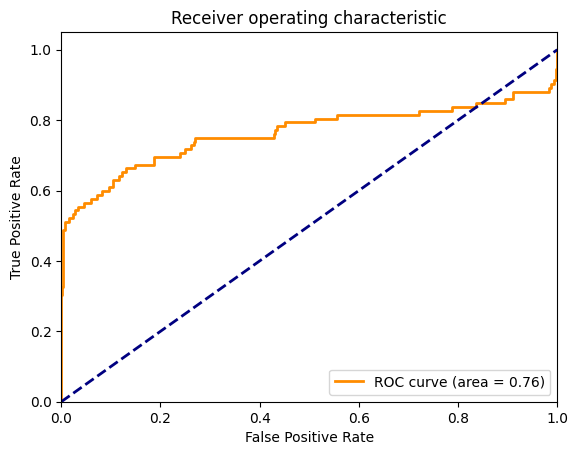

In [ ]:
#scale data to have mean 0 and sd 1
scaler = StandardScaler()
X_train_logit = scaler.fit_transform(X_train)

# Fit a logistic regression.
# Increase max_iter to allow for convergence
Logis_model = LogisticRegression(max_iter=1000)
Logis_model.fit(X_train_logit, y_train)

#ensure test set is transformed using the same mean and sd as with the training data
X_test_logit = scaler.transform(X_test)

# Predict on the test set.
Logis_y_preds = Logis_model.predict(X_test_logit)
Logis_y_probs = Logis_model.predict_proba(X_test_logit)[:,1]

# Display the confusion matrix.
print(confusion_matrix(y_test, Logis_y_preds))

# Evaluate the fitted logistic regression.
# Display ROC-AUC and PR-AUC as well as plot
eval_model(y_test, Logis_y_probs)

### Decision Tree (may consider other models)

[[695  40]
 [ 36  65]]
ROC-AUC: 0.7945712938640803 
 PR-AUC 0.6528370882201002


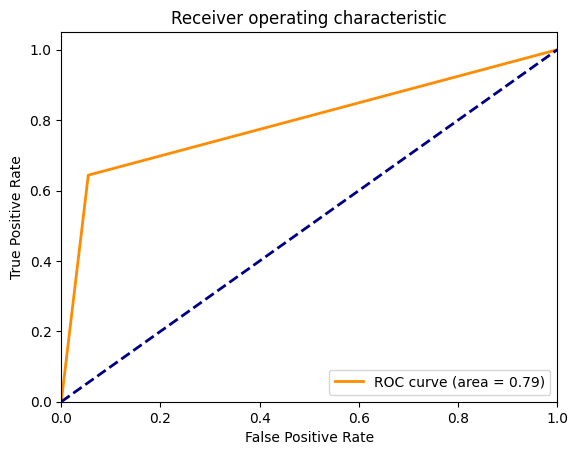

In [ ]:
# Fit a decision tree.
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train, y_train)

# Predict on the test set.
DT_y_preds = DT_model.predict(X_test)
DT_y_probs = DT_model.predict_proba(X_test)[:,1]

# Display confusion matrix.
print(confusion_matrix(y_test, DT_y_preds))

# Evaluate the fitted decision tree.
eval_model(y_test, DT_y_probs)

### Random Forest

[[734   1]
 [ 47  54]]
ROC-AUC: 0.8835859096113693 
 PR-AUC 0.7530024842300123


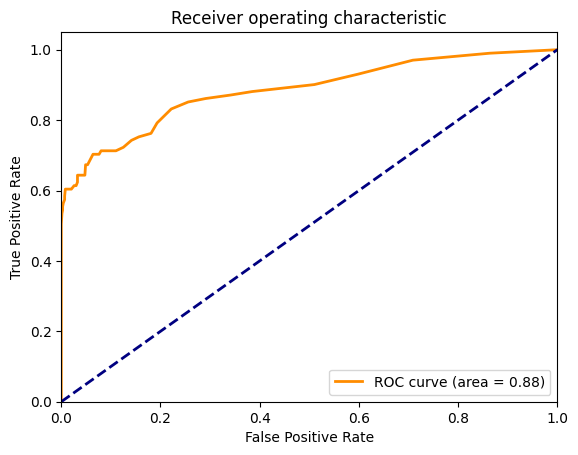

In [ ]:
# Fit a random forest classifier.
RF_model = RandomForestClassifier()
RF_model.fit(X_train, y_train)

# Predict on the test set.
RF_y_preds = RF_model.predict(X_test)
RF_y_probs = RF_model.predict_proba(X_test)[:,1]

# Display confusion matrix.
print(confusion_matrix(y_test, RF_y_preds))

# Evaluate the fitted random forest.
eval_model(y_test, RF_y_probs)

In [ ]:
# SVM
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# train SVM model
for c in range(1, 10, 1):
  svm = SVC(C = c, kernel='rbf', probability = True)
  svm.fit(X_train, y_train)


  # Predict on the test set.
  # SVM_y_preds = svm.predict(X_test)
  SVM_y_probs = svm.predict_proba(X_test)[:,1]

  # Display confusion matrix.
  # print(confusion_matrix(y_test, SVM_y_preds))

  # Evaluate the fitted random forest.
  eval_model(y_test, SVM_y_probs)

## Class for tuning

In [68]:
class HyperparameterTuner:
    def __init__(self, estimator, n_inner, n_iter, search_method, eval_metric, param_grid, setting=None):
        self.estimator = estimator
        self.n_inner = n_inner
        self.n_iter = n_iter
        self.search_method = search_method
        self.eval_metric = eval_metric
        self.param_grid = param_grid
        self.setting = setting


    def grid_search(self, X, y):
        inner_cv = StratifiedKFold(n_splits=self.n_inner, shuffle=True, random_state=841)

        if self.setting is None:
            estimator = self.estimator()
        else:
            estimator = self.estimator(**self.setting)
        self.grid_search = GridSearchCV(
            estimator= estimator,
            param_grid = self.param_grid,
            cv=inner_cv,
            scoring="recall",
            n_jobs=-1, refit = False)
        
        # Perform the inner CV to search for the best hyperparameters.
        self.grid_search.fit(X, y)

        self.results = self.grid_search.cv_results_
        self.best_params = self.grid_search.best_params_

        # Train the model on the entire training set using the best hyperparameters.
        if self.setting is None:
            self.best_model = self.estimator(**self.grid_search.best_params_)
        else:
            self.best_model = self.estimator(**self.grid_search.best_params_, **self.setting)


    def random_search(self, X, y):
        inner_cv = StratifiedKFold(n_splits=self.n_inner, shuffle=True, random_state=841)
        if self.setting is None:
            estimator = self.estimator()
        else:
            estimator = self.estimator(**self.setting)
        self.random_search = RandomizedSearchCV(
            estimator = estimator,
            param_distributions = self.param_grid,
            n_iter = self.n_iter,
            cv=inner_cv,
            scoring="recall",
            n_jobs=-1, refit = False)
        
        # Perform the inner CV to search for the best hyperparameters.
        self.random_search.fit(X, y)

        self.results = self.random_search.cv_results_
        if self.setting is None:
            self.best_model = self.estimator(**self.random_search.best_params_)
        else:
            self.best_model = self.estimator(**self.random_search.best_params_, **self.setting)
        self.best_params = self.random_search.best_params_


    def tune_param(self, X, y):
        if self.search_method == "grid":
            self.grid_search(X, y)
        elif self.search_method == "random":
            self.random_search(X, y)
        else:
            raise ValueError("Invalid method specified, check the search_method")


    def get_score(self):

        self.test_score_per_fold = []
        for i in range(self.n_inner):
          self.test_score_per_fold.append(self.results['split{}_test_score'.format(i)])
        self.mean_test_score = self.results["mean_test_score"]


    # plot when there is only one parameter in the grid.
    def plot_CV_scores(self):

        self.get_score()
        for i in range(len(self.test_score_per_fold)):
          
            plt.plot(np.array(list(self.param_grid.values())).reshape((len(list(self.param_grid.values())[0]), 1)), 
                self.test_score_per_fold[i].reshape(-1, 1), 
                label='fold {}'.format(i+1), linewidth = 1)
            
        plt.plot(np.array(list(self.param_grid.values())).reshape((len(list(self.param_grid.values())[0]), 1)), 
            self.mean_test_score.reshape(-1, 1), 
            label = "avg", linewidth = 5)

        # Add legend and show plot.
        plt.legend()
        plt.xlabel(list(self.param_grid.keys())[0])
        plt.ylabel("Recall Score")
        plt.title(f'{list(self.param_grid.keys())[0]} tuning')
        plt.show()

    # plot with respect to one parameter.
    def plot_param_CV_scores(self, param_name):

        self.get_score()
        param_list = list(self.results['param_' + param_name].data)
        for i in range(len(self.test_score_per_fold)):
          
            plt.plot(np.array(param_list).reshape((len(param_list), 1)), 
                self.test_score_per_fold[i].reshape(-1, 1), 
                label='fold {}'.format(i+1), linewidth = 1)
            
        plt.plot(np.array(param_list).reshape((len(param_list), 1)), 
            self.mean_test_score.reshape(-1, 1), 
            label = "avg", linewidth = 5)

        # Add legend and show plot.
        plt.legend()
        plt.xlabel(param_name)
        plt.ylabel("Recall Score")
        plt.title(f'{param_name} tuning')
        plt.show()



    # Can create nested_cv function using for loop
    def nested_cv(self, X, y, n_outer_folds):
        # Empty matrix to store values with a size (n_outer x n_inner)
        nested_scores = np.zeros((n_outer_folds, 3))
        # Kfold for outer splitting
        # outer_cv = KFold(n_splits= n_outer_folds, shuffle=True, random_state=841)

        # do we need to use stratified k fold because dataset is imbalanced?
        outer_cv = StratifiedKFold(n_splits= n_outer_folds, shuffle=True, random_state=841)
        # index for value storing matrix
        i=0
        for train_index, test_index in outer_cv.split(X):
            print(f"Outer Fold: {i+1}")
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_test, y_test = X.iloc[test_index], y.iloc[test_index]
            self.tune_param(X_train, y_train)

            outer_estimator = self.best_model
            outer_estimator.fit(X_train, y_train)
            # generate predictions on the test set
            y_pred = outer_estimator.predict(X_test)
            y_probs = outer_estimator.predict_proba(X_test)[:,1]
            # compute the score of the model on the test set
            nested_scores[i,0] = accuracy_score(y_test, y_pred)
            nested_scores[i,1] = f1_score(y_test, y_pred)
            nested_scores[i,2] = roc_auc_score(y_test, y_probs)
            i += 1

        mean_scores = np.mean(nested_scores, axis=0)

        print(f"\nAverage accuracy score: {mean_scores[0]:.2f}")
        print(f"Average F1 score: {mean_scores[1]:.2f}")
        print(f"Average ROC AUC score: {mean_scores[2]:.2f}") 

        return(nested_scores)


    # For random forest model.
    def rf_variable_importance(self, X, y):
      rf = self.best_model
      rf.fit(X, y)
      importances = rf.feature_importances_
      df_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
      df_importances = df_importances.sort_values('importance', ascending=False).reset_index(drop=True)
      print("Feature ranking:")
      print(df_importances)
      df_importances.plot(kind='bar', x='feature', y='importance', title='Feature importances', legend=False)

    def save_result(self, filename):
      if self.search_method == "grid":
        joblib.dump(self.grid_search, filename + '.joblib')
      elif self.search_method == "random":
        joblib.dump(self.random_search, filename + '.joblib')
      else:
        raise ValueError("Invalid method specified, check the search_method")
    
    def load_result(self, filename):
      if self.search_method == "grid":
        self.grid_search = joblib.load(filename + '.joblib')
      elif self.search_method == "random":
        self.random_search = joblib.load(filename + '.joblib')
      else:
        raise ValueError("Invalid method specified, check the search_method")


### Try for rf to tune and plot


First We tune the random forest with random search for a large grid of all variables to estimate an approximate of the parameters. As mentioned in proposal, we can tune the tree for
 1. max number of features
 2. stop criteria

  2.1 num of min samples for each leaf

  2.2 max depth of tree

  2.3 min num of samples required to split a tree

3. choice of loss function.


In [ ]:
rf_tuner = HyperparameterTuner(
    estimator=RandomForestClassifier,
    n_inner = 5,
    search_method = "random",
    eval_metric = "recall",
    n_iter = 100,
    param_grid = {
        "min_samples_leaf": randint(1, 100),
        "max_depth": randint(1, 100),
        "min_samples_split": randint(2, 100),
        "criterion":["gini", "entropy", "log_loss"]},
        setting = {"n_estimators": 400, "class_weight": "balanced", "max_features": "sqrt"}

    )

# Tune the hyperparameter on the data.
rf_tuner.tune_param(X_train, y_train)
# Return the best model for next step.
rf_tuner.best_model
rf_tuner.save_result('testrandom')
rf_tuner.load_result("testrandom")
rf_tuner.random_search
# rf_tuner.plot_param_CV_scores("min_samples_leaf")

In [ ]:
rf_tuner.results
# how to sort and plot results

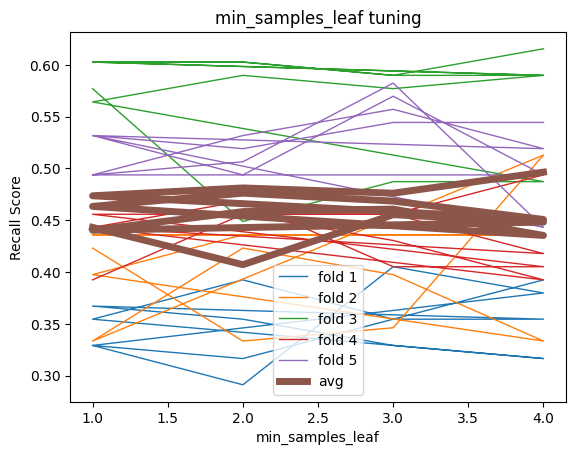

In [69]:
rf_tuner2 = HyperparameterTuner(
    estimator=RandomForestClassifier,
    n_inner = 5,
    search_method = "grid",
    eval_metric = "recall",
    n_iter = 3,
    param_grid = {
        "min_samples_leaf": np.arange(1, 5, 1).tolist(),
        "max_depth": np.arange(1, 5, 1).tolist()},
        setting = {"n_estimators": 300, "class_weight": "balanced"}

    )
        # "min_samples_split": np.arange(2, 10, 1).tolist(),
        # "criterion":["gini", "entropy", "log_loss"],
        # "max_features": ["sqrt", "log2", None]},
# Tune the hyperparameter on the data.
rf_tuner2.tune_param(X_train, y_train)
# Return the best model for next step.
rf_tuner2.best_model
rf_tuner2.save_result('testgrid')
rf_tuner2.load_result("testgrid")
rf_tuner2.grid_search
rf_tuner2.plot_param_CV_scores("min_samples_leaf")

In [70]:
rf_tuner2.results['param_max_depth'].data

{'mean_fit_time': array([1.02410321, 0.77263923, 1.11920152, 0.78256102, 0.95709348,
        0.94172902, 0.98748074, 1.30605593, 1.1273581 , 1.12554946,
        1.17062922, 1.48026595, 1.31421576, 1.32440119, 1.71636262,
        1.31034555]),
 'std_fit_time': array([0.2052302 , 0.01344446, 0.27806572, 0.05374389, 0.00773737,
        0.00452378, 0.07532857, 0.36703627, 0.01736881, 0.01336939,
        0.08349994, 0.31841809, 0.00985291, 0.02031286, 0.5033201 ,
        0.00801434]),
 'mean_score_time': array([0.07065449, 0.0507987 , 0.07890625, 0.05112357, 0.05065098,
        0.05287457, 0.05819173, 0.05941763, 0.05003419, 0.04624076,
        0.0489378 , 0.06105204, 0.05307775, 0.05590143, 0.05358572,
        0.04976301]),
 'std_score_time': array([0.0219    , 0.00143982, 0.0220117 , 0.0026945 , 0.00338495,
        0.00234016, 0.01236701, 0.01334559, 0.00497482, 0.00122527,
        0.00194287, 0.01667494, 0.00352791, 0.00173918, 0.00361899,
        0.00851841]),
 'param_max_depth': masked

In [52]:
rf_tuner.results['param_min_samples_leaf'].data

array([12, 94, 8, 26, 21], dtype=object)

In [48]:
# list(rf_tuner.random_search.cv_results_['param_max_depth'].data)

rf_tuner.plot_param_CV_scores("min_samples_leaf")

AttributeError: ignored

In [ ]:
self, estimator, n_inner, search_method, eval_metric, param_grid,

In [ ]:
param_grid = {
    "n_estimators": [100, 200],
    # "max_depth": [5, 10, 20],
    "max_depth": np.arange(1, 20, 2).tolist(),
    # "min_samples_split": [2, 5, 10],
    "min_samples_split": np.arange(1, 20, 5).tolist(),
    # "min_samples_leaf": [1, 2, 4],
    "min_samples_leaf": np.arange(1, 10, 1).tolist(),
    "criterion":["gini", "entropy", "log_loss"],
    "class_weight": ["balanced", "balanced_subsample", None],
    "max_features": ["sqrt", "log2", None]
    
}

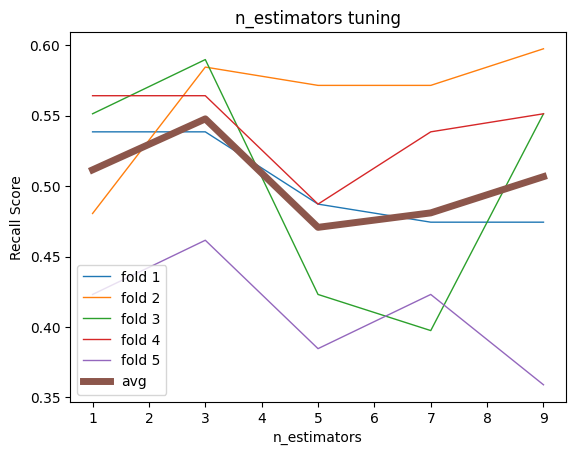

Feature ranking:
   feature  importance
0   P_J302    0.061649
1     F_V2    0.055020
2   P_J300    0.050882
3    F_PU7    0.049626
4    S_PU6    0.047806
5   P_J307    0.047628
6    F_PU8    0.045936
7   P_J415    0.045402
8    P_J14    0.042622
9   P_J256    0.041458
10   F_PU6    0.040648
11    L_T1    0.036815
12    L_T4    0.035626
13  P_J422    0.034735
14  P_J306    0.033466
15   F_PU1    0.032140
16  P_J317    0.031163
17    L_T2    0.027087
18  P_J269    0.025392
19    L_T7    0.023833
20  P_J289    0.022779
21  F_PU10    0.022740
22   F_PU2    0.021404
23    L_T3    0.021282
24    L_T6    0.019679
25   S_PU7    0.018438
26    L_T5    0.017997
27   F_PU4    0.012489
28  S_PU11    0.009650
29   S_PU2    0.005925
30  F_PU11    0.005432
31  S_PU10    0.005139
32  P_J280    0.003866
33   S_PU8    0.002865
34   S_PU4    0.000755
35    S_V2    0.000628
36   S_PU1    0.000000
37   S_PU9    0.000000
38   F_PU9    0.000000
39   F_PU3    0.000000
40   S_PU5    0.000000
41   F_PU5    0.0

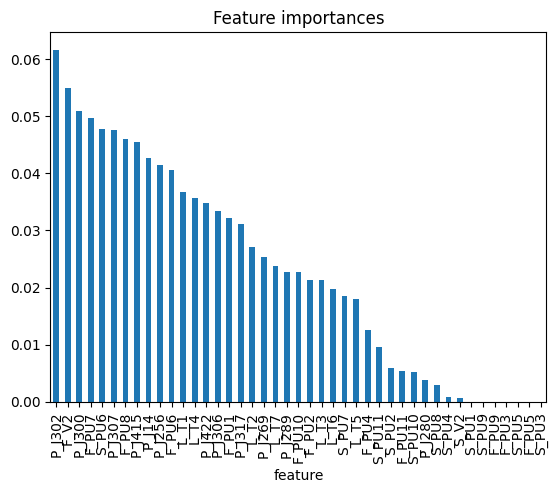

In [ ]:
rf_tuner = HyperparameterTuner(
    estimator=RandomForestClassifier,
    n_inner = 5,
    search_method = "grid",
    eval_metric = "recall",
    param_grid = {"n_estimators": np.arange(1, 10, 2)},
    )

# Tune the hyperparameter on the data.
rf_tuner.tune_param(X_train, y_train)
# Plot the cv error per fold vs tuning parameter.
rf_tuner.plot_CV_scores()
# Return the best model for next step.
rf_tuner.best_model
# Plot the variable importance for random forests for final model.
rf_tuner.rf_variable_importance(X_train, y_train)

In [ ]:
print(rf_tuner.best_params)
print(rf_tuner.setting)

{'n_estimators': 3}
None


### Hide

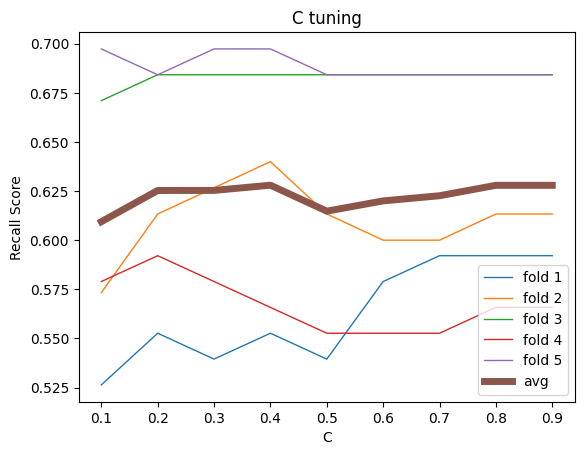

In [ ]:
logis_tuner = HyperparameterTuner(
    estimator=LogisticRegression,
    n_inner = 5,
    search_method = "grid",
    eval_metric = "recall",
    param_grid = {"C": np.arange(0.1, 1, 0.1)},
    setting = { "solver" :'liblinear', "class_weight": "balanced", "max_iter": 1000}
    )
scaler = StandardScaler()
# df.columns = df.columns.astype(str)
scaler.fit_transform(X_train)
X_logit_scaled = scaler.transform(X_train)
# Tune the hyperparameter on the data.
logis_tuner.tune_param(X_logit_scaled, y_train)
# Plot the cv error per fold vs tuning parameter.
logis_tuner.plot_CV_scores()

In [ ]:
# Evaluate on an unseen test set.
logis_tuner.best_model.fit(X_logit_scaled, y_train)
test_scaler = StandardScaler()
test_scaler.fit_transform(X_test)
X_logit_scaled_test = test_scaler.transform(X_test)
logit_y_preds = logis_tuner.best_model.predict(X_logit_scaled_test)
test_score = recall_score(y_test, logit_y_preds)
test_score

0.6460176991150443

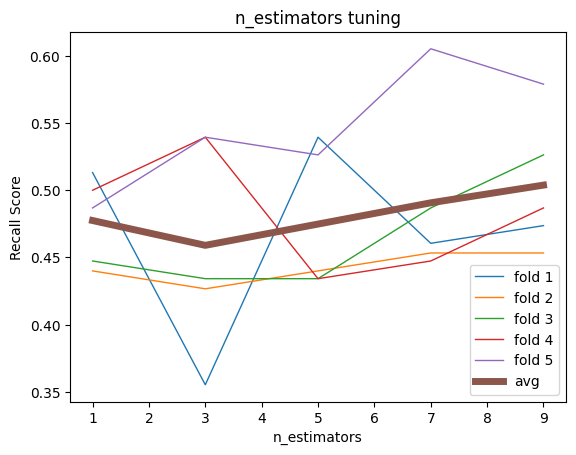

In [ ]:
rf_tuner = HyperparameterTuner(
    estimator=RandomForestClassifier,
    n_inner = 5,
    search_method = "grid",
    eval_metric = "recall",
    param_grid = {"n_estimators": np.arange(1, 10, 2)},
    )

# Tune the hyperparameter on the data.
rf_tuner.tune_param(X_train, y_train)
# Plot the cv error per fold vs tuning parameter.
rf_tuner.plot_CV_scores()

In [ ]:
rf_tuner.results

{'mean_fit_time': array([2.03534398, 1.66469412, 3.37155881, 2.2961256 ]),
 'std_fit_time': array([0.60414606, 0.04916981, 1.32533579, 0.44158412]),
 'mean_score_time': array([0.05701709, 0.03547816, 0.05061035, 0.03753066]),
 'std_score_time': array([0.01937396, 0.00105486, 0.01968911, 0.00715994]),
 'param_class_weight': masked_array(data=[{0: 0.2, 1: 0.8}, {0: 0.4, 1: 0.6},
                    {0: 0.6000000000000001, 1: 0.3999999999999999},
                    {0: 0.8, 1: 0.19999999999999996}],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'class_weight': {0: 0.2, 1: 0.8}},
  {'class_weight': {0: 0.4, 1: 0.6}},
  {'class_weight': {0: 0.6000000000000001, 1: 0.3999999999999999}},
  {'class_weight': {0: 0.8, 1: 0.19999999999999996}}],
 'split0_test_score': array([0.43421053, 0.46052632, 0.44736842, 0.46052632]),
 'split1_test_score': array([0.32      , 0.38666667, 0.38666667, 0.38666667]),
 'split2_test_score': array([

In [ ]:
# Plot the variable importance for random forests.
rf_tuner.rf_variable_importance(X_train, y_train)

# 以下code暂时先不管

In [ ]:
# 别动！！！
# class HyperparameterTuner:
#     def __init__(self, estimator, param_name, param_range, n_trials, n_inner, n_outer, search_method, eval_metric, param_grid, setting=None):
#         self.estimator = estimator
#         self.param_name = param_name
#         self.param_range = param_range
#         self.n_trials = n_trials
#         self.n_inner = n_inner
#         self.n_outer = n_outer
#         self.search_method = search_method
#         self.eval_metric = eval_metric
#         self.param_grid = param_grid
#         # self.X = X
#         # self.y = y
#         # takes a dictonary of parameters eg. {penalty:"l1"}
#         self.setting = setting
#         self.param_values = None
#         self.scores = None
#         self.best_param_value = None
#         self.best_score = None

#     def grid_range(self):
#         estimator_param = getattr(self.estimator(), self.param_name)
#         param_dtype = type(estimator_param)
#         if self.search_method == "grid":
#             self.param_values = np.linspace(self.param_range[0], self.param_range[1], self.n_trials, dtype = param_dtype)
#         elif self.search_method == "random":
#             if param_dtype == int:
#                 random.seed(841)
#                 self.param_values = np.random.randint(self.param_range[0], self.param_range[1], self.n_trials)
#             if param_dtype == float:
#                 random.seed(841)
#                 self.param_values = np.random.uniform(self.param_range[0], self.param_range[1], self.n_trials)
#         else:
#           raise ValueError("Invalid method specified, check the search_method or the param_name")

#     def tune_param(self, X, y):
#         self.grid_range()
#         # cv = KFold(n_splits= self.n_inner, shuffle=True, random_state=841)

#         # do we need to use stratified k fold because dataset is imbalanced?
#         cv = StratifiedKFold(n_splits= self.n_inner, shuffle=True, random_state=841)
#         self.scores = []

#         for param_value in tqdm(self.param_values):
#             if self.setting is None:
#                 estimator = self.estimator(**{self.param_name: param_value})
#             else:
#                 estimator = self.estimator(**{self.param_name: param_value}, **self.setting)
#             #########################
#             # Can we just use cross_val_score?
#             scores = cross_val_score(estimator, X, y, cv=cv, scoring=self.eval_metric)
#             ########################
#             mean_score = np.mean(scores)
#             self.scores.append(mean_score)
#             # scores size = num of folds
#             if (self.best_score is None) or (mean_score > self.best_score):
#                 self.best_score = mean_score
#                 self.best_param_value = param_value

#     def grid_search(self, X, y):
#       inner_cv = StratifiedKFold(n_splits= self.n_inner, shuffle=True, random_state=841)
#       grid_search = GridSearchCV(
#           estimator=self.estimator(**self.setting),
#           param_grid=self.param_grid,
#           cv=inner_cv,
#           scoring="recall",
#           n_jobs=-1, refit = False)
      
#       # perform the inner CV to search for the best hyperparameters
#       grid_search.fit(X, y)

#       self.grid_results = grid_search.cv_results_
#       self.best_grid_param = grid_search.best_params_

#       # train the model on the entire training set using the best hyperparameters
#       self.model = self.estimator(**grid_search.best_params_, **self.setting)
#       # self.model.fit(X, y)


#     def random_search(self, X, y):
#       inner_cv = StratifiedKFold(n_splits= self.n_inner, shuffle=True, random_state=841)
#       random_search = RandomizedSearchCV(
#           estimator=self.estimator(**self.setting),
#           param_grid=self.param_grid,
#           cv=inner_cv,
#           scoring="recall",
#           n_jobs=-1, refit = False)
      
#       # perform the inner CV to search for the best hyperparameters
#       random_search.fit(X, y)

#       self.random_results = random_search.cv_results_
#       self.random_model = self.estimator(**random_search.best_params_, **self.setting)
#       self.best_random_param = random_search.best_params_

#     def get_score(self):
#       self.test_score_per_fold = []
#       for i in range(self.n_inner):
#         self.test_score_per_fold.append(self.grid_results['split{}_test_score'.format(i)])
#       self.mean_test_score = self.grid_results["mean_test_score"]

#     # plot when there is only one parameter in the grid
#     def plot_CV_scores(self):

#       for i in range(len(self.test_score_per_fold)):
        
#         plt.plot(np.array(list(self.param_grid.values())).reshape((len(list(self.param_grid.values())[0]), 1)), self.test_score_per_fold[i].reshape(-1, 1), label='fold {}'.format(i+1), linewidth = 1)
#       plt.plot(np.array(list(self.param_grid.values())).reshape((len(list(self.param_grid.values())[0]), 1)), self.mean_test_score.reshape(-1, 1), label = "avg", linewidth = 5)

#         # Add legend and show plot
#       plt.legend()
#       # plt.show()

#       # plt.plot(self.param_values, self.scores)
#       plt.xlabel(list(self.param_grid.keys())[0])
#       plt.ylabel("Recall Score")
#       plt.title(f'{list(self.param_grid.keys())[0]} tuning')
#       plt.show()



#     # Can create nested_cv function using for loop
#     def nested_cv(self, X, y, n_outer_folds):
#         # Empty matrix to store values with a size (n_outer x n_inner)
#         nested_scores = np.zeros((n_outer_folds, 3))
#         # Kfold for outer splitting
#         # outer_cv = KFold(n_splits= n_outer_folds, shuffle=True, random_state=841)

#         # do we need to use stratified k fold because dataset is imbalanced?
#         outer_cv = StratifiedKFold(n_splits= n_outer_folds, shuffle=True, random_state=841)
#         # index for value storing matrix
#         i=0
#         for train_index, test_index in outer_cv.split(X):
#             print(f"Outer Fold: {i+1}")
#             X_train, y_train = X.iloc[train_index], y.iloc[train_index]
#             X_test, y_test = X.iloc[test_index], y.iloc[test_index]
#             self.tune_param(X_train, y_train)

#             if self.setting is None:
#                 outer_estimator = self.estimator(**{self.param_name:self.best_param_value})
#             else:
#                 outer_estimator = self.estimator(**{self.param_name:self.best_param_value}, **self.setting)
#             outer_estimator.fit(X_train, y_train)
#             # generate predictions on the test set
#             y_pred = outer_estimator.predict(X_test)
#             y_probs = outer_estimator.predict_proba(X_test)[:,1]
#             # compute the score of the model on the test set
#             nested_scores[i,0] = accuracy_score(y_test, y_pred)
#             nested_scores[i,1] = f1_score(y_test, y_pred)
#             nested_scores[i,2] = roc_auc_score(y_test, y_probs)
#             i += 1

#         mean_scores = np.mean(nested_scores, axis=0)

#         print(f"\nAverage accuracy score: {mean_scores[0]:.2f}")
#         print(f"Average F1 score: {mean_scores[1]:.2f}")
#         print(f"Average ROC AUC score: {mean_scores[2]:.2f}") 

#         return(nested_scores)
        

#     def plot_scores(self):

#         plt.plot(self.param_values, self.scores)
#         plt.xlabel(self.param_name)
#         plt.ylabel(self.eval_metric)
#         plt.title(f'{self.param_name} tuning')
#         plt.show()

#     # forfor random forest model
#     def rf_variable_importance(self, X, y):
#       rf = self.model
#       rf.fit(X, y)
#       importances = rf.feature_importances_
#       df_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
#       df_importances = df_importances.sort_values('importance', ascending=False).reset_index(drop=True)
#       print("Feature ranking:")
#       print(df_importances)
#       df_importances.plot(kind='bar', x='feature', y='importance', title='Feature importances', legend=False)


In [ ]:
xgb_tuner = HyperparameterTuner(
    estimator = xgb.XGBClassifier,
    param_name = 'eta',
    param_range = (0, 1),
    n_trials = 15,
    n_inner = 5,
    search_method = "Grid_Float",
    eval_metric = "recall",
    setting = {"scale_pos_weight":7.4}
)
# tune the hyperparameter on the data
xgb_tuner.tune_param(X, y)

# # plot the results
# xgb_tuner.plot_scores()

# xgb_tuner.nested_cv(X, y, 5)

100%|██████████| 15/15 [02:01<00:00,  8.11s/it]


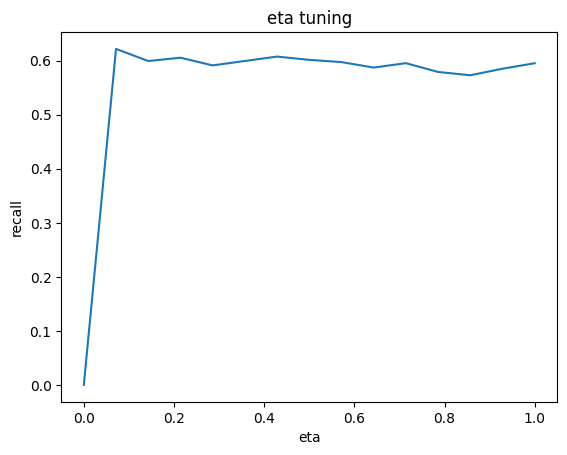

[0.0,
 0.6217687074829932,
 0.5994021851164708,
 0.6055040197897341,
 0.5912801484230055,
 0.5994846423417852,
 0.607586064728922,
 0.6015254586683157,
 0.5973819830962689,
 0.5872603586889301,
 0.595403009688724,
 0.5791177076891363,
 0.5730364873222016,
 0.5851576994434138,
 0.5953205524634096]

In [ ]:
xgb_tuner.plot_scores()
xgb_tuner.scores

In [ ]:
xgb_tuner.scores
# xgb_tuner.best_param_value
# xgb_tuner.best_score
#[0.9185978282669112,
#  0.9200340944904448,
#  0.9233848093287109,
#  0.9288909262814086,
#  0.9351170386499728]

[0.43898165326736754,
 0.5222428365285507,
 0.5283652855081427,
 0.5384869099154813,
 0.5486497629354773]

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

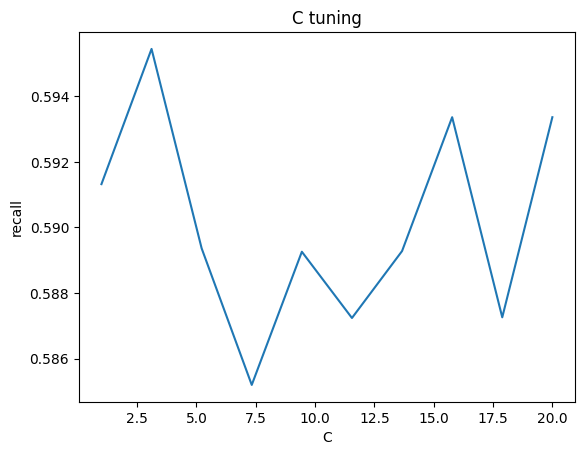

[0.5913213770356627,
 0.5954442383013812,
 0.5893630179344465,
 0.5851989280560709,
 0.5892599464028034,
 0.5872397443826015,
 0.5892805607091322,
 0.5933621933621934,
 0.5872603586889301,
 0.5933621933621934]

In [ ]:
svm_tuner = HyperparameterTuner(
    estimator=LogisticRegression,
    param_name='C',
    param_range = (1, 20),
    n_trials= 10,
    n_inner = 5,
    search_method = "Grid_Float",
    eval_metric = "recall",
    setting = { "class_weight": "balanced"}

    # , "class_weight": "balanced", "max_iter": 1000
    # "probability": True, "kernel" :'rbf',
)
# scaler = StandardScaler()
# X_logit = scaler.fit_transform(X)
# tune the hyperparameter on the data
svm_tuner.tune_param(X, y)

# plot the results
svm_tuner.plot_scores()
svm_tuner.scores


In [ ]:
outer_cv = KFold(n_splits= 5, shuffle=True, random_state=841)
for train_index, test_index in outer_cv.split(X):
   print(test_index)

## GPT nested CV

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

# Number of folds
n_outer = 10
n_inner = 10

# Outer fold splitting with KFold
outer_cv = StratifiedKFold(n_splits=n_outer, shuffle=True, random_state=841)
inner_cv = StratifiedKFold(n_splits=n_inner, shuffle=True, random_state=841)

In [ ]:
# Parameter for grid search
param_grid = {
    "n_estimators": [100, 200],
    # "max_depth": [5, 10, 20],
    "max_depth": np.arange(1, 20, 2).tolist(),
    # "min_samples_split": [2, 5, 10],
    "min_samples_split": np.arange(1, 20, 5).tolist(),
    # "min_samples_leaf": [1, 2, 4],
    "min_samples_leaf": np.arange(1, 10, 1).tolist(),
    "criterion":["gini", "entropy", "log_loss"],
    "class_weight": ["balanced", "balanced_subsample", None],
    "max_features": ["sqrt", "log2", None]
    
}


In [ ]:
# create an empty list to store the test scores for each outer fold
test_scores = []

outer_cv.split(X)
# loop over the outer CV folds
for train_ix, test_ix in outer_cv.split(X):
    
    # split the data into training and test sets for the outer fold
    X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
    X_test, y_test = X.iloc[test_ix], y.iloc[test_ix]

    # set up the inner loop to search for the best hyperparameters
    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid=param_grid,
        cv=inner_cv,
        scoring="accuracy",
        n_jobs=-1
    )

    # perform the inner CV to search for the best hyperparameters
    grid_search.fit(X_train, y_train)

    # train the model on the entire training set using the best hyperparameters
    model = RandomForestClassifier(**grid_search.best_params_)
    model.fit(X_train, y_train)

    # evaluate the model on the test set for the outer fold
    test_score = model.score(X_test, y_test)
    test_scores.append(test_score)

# calculate the average test score across all outer folds
avg_test_score = np.mean(test_scores)


KeyboardInterrupt: ignored